In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(60000, 28, 28)
(60000,)
(10000,)
(10000, 28, 28)


In [4]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(60000, 784)
(60000,)
(10000,)
(10000, 784)


In [5]:
Y_train = np.zeros((len(y_train),10))
for i in range(len(y_train)):
    Y_train[i,y_train[i]] = 1

Y_test = np.zeros((len(y_test),10))
for j in range(len(y_test)):
    Y_test[j,y_test[j]] = 1

In [6]:
# Y_train = np.array(y_train).reshape(1,-1)
# Y_test = np.array(y_test).reshape(1,-1)

In [7]:
print(x_train.shape)
print(Y_train.shape)
print(x_test.shape)
print(Y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


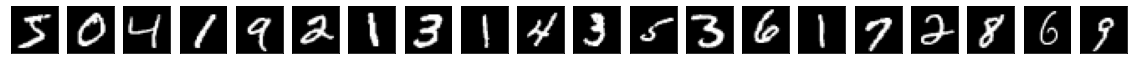

In [8]:
n = 20  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

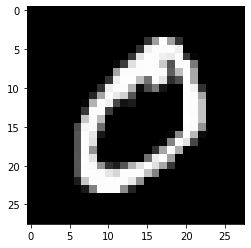

In [9]:
XX_train = x_train.astype('float32') / 255.
XX_test = x_test.astype('float32') / 255.
plt.imshow(XX_train[1].reshape(28,28))

In [10]:
XX_train = XX_train.T
XX_test = XX_test.T
Y_train = Y_train.T
Y_test = Y_test.T
# Y_train = Y_train.reshape(1,-1)
# Y_test = Y_test.reshape(1,-1)
print(XX_train.shape)
print(Y_train.shape)
print(XX_test.shape)
print(Y_test.shape)

(784, 60000)
(10, 60000)
(784, 10000)
(10, 10000)


In [11]:
print(XX_test.shape)

(784, 10000)


In [12]:
def softmax(Z):
	expZ = np.exp(Z - np.max(Z))
	return expZ / expZ.sum(axis=0, keepdims=True)

In [13]:
def sigmoid(Z):      
    A = 1/(1+np.exp(-Z))       
    return A

In [14]:
def deep_initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])# *0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

In [15]:
def linear_activation_forward(A_prev, W, b, activation):
    Z = np.dot(W,A_prev) + b
    linear_cache = (A_prev, W, b)
        
    if activation == "softmax":    
        A = softmax(Z)
    elif activation == "sigmoid":
        A = sigmoid(Z)
    
    cache = (linear_cache, Z)
    return A, cache  

In [16]:
def deep_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "sigmoid")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)
    return AL, caches

In [17]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m)*np.sum(Y * np.log(AL))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    return cost

In [18]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

In [19]:
def sigmoid_backward(dA, cache):
    Z = cache    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)    
    return dZ

In [20]:
def softmax_backward(AL,Y,cache):
    Z = cache
    dZ = AL - Y
    assert (dZ.shape == Z.shape)
    return dZ


In [21]:
def linear_activation_backward(Y,AL,dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "softmax":
        dZ = softmax_backward(AL,Y,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [22]:
def deep_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(Y,AL,dAL, current_cache, activation = "softmax")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(Y,AL,grads["dA" + str(l + 2)], current_cache, activation = "sigmoid")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads  

In [23]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [24]:
def deep_layer_model(X, Y, layers_dims, learning_rate, num_iterations): #lr was 0.009
    costs = []
    parameters = deep_initialize_parameters(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = deep_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = deep_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        costs.append(cost)
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
    return parameters, costs

In [25]:
layers_dims = [XX_train.shape[0], 256, 64,32,10]
print(len(layers_dims))
par, costs = deep_layer_model(XX_train, Y_train, layers_dims, learning_rate=0.1, num_iterations=10)


5
Cost after iteration 0: 2.499047


In [30]:
print(costs) # minimal change in loss

[13.34482580777035, 13.344956704672558, 13.345089418470375, 13.345223952327878, 13.345360309411838, 13.345498492890624, 13.345638505933177, 13.345780351707967, 13.345924033381936, 13.346069554119522]


In [79]:
def predict(X,Y,parameters):
       m = X.shape[1]
       p = np.zeros((1, m),dtype=int)
       probs, caches = deep_model_forward(X, parameters) 
       for i in range(0, probs.shape[1]):
        if probs[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
       print("Accuracy: %s" % str(np.sum(p == Y)/float(m)))
       print(np.sum(p == Y))


In [82]:
 #def predict(X, Y,parameters):
A, pre_cache = deep_model_forward(XX_train,par)

        #return accuracy * 100

In [83]:
y_hat = np.argmax(A, axis=0)
len(y_hat)

60000

In [84]:
 Y_pre = np.argmax(Y_train, axis=0)
 len(Y_pre)

60000

In [90]:
accuracy = (y_hat == Y_pre).sum()/60000

In [91]:
accuracy*100

9.921666666666667

In [74]:
print(par)

{'W1': array([[ 0.05801233, -0.02184844, -0.01886328, ..., -0.03952047,
        -0.01282943,  0.01804935],
       [ 0.04349789, -0.06931003, -0.02879208, ...,  0.00740107,
        -0.05121538,  0.02238951],
       [ 0.01070804, -0.06630862, -0.07682297, ..., -0.06979256,
         0.00665085, -0.00013678],
       ...,
       [-0.02192387, -0.01253738,  0.00178815, ..., -0.0052669 ,
        -0.06138786, -0.04224726],
       [-0.00582206,  0.04913985, -0.01427658, ..., -0.00262458,
        -0.02744943, -0.0344641 ],
       [-0.01399487,  0.01330811, -0.02041592, ...,  0.04375963,
        -0.00999483,  0.02420322]]), 'b1': array([[ 8.09065671e-08],
       [-1.98102691e-07],
       [-4.60287165e-08],
       [ 4.61100289e-08],
       [ 2.92817466e-08],
       [ 6.94218533e-09],
       [ 1.45092562e-07],
       [ 1.69057650e-07],
       [ 1.63899499e-07],
       [-5.84649632e-08],
       [ 1.71740657e-08],
       [-4.18034004e-08],
       [-1.33947025e-07],
       [-1.80628170e-07],
       [ 